# SOP - Quality Control Steps 

This SOP will focus on QC steps that should be run prior to DGE analysis. This will include filtering, normalization and clustering analysis of the data. This will give context to and ensure the validity of results in DGE analysis. 

# Step 1 - Loading Libraries
The first step is to load libraries. Pandas, seaborn and numpy are essential. Scipy will help with the PCA analysis later on. Matplot lib makes some of the plottig easier


In [2]:
import pandas as pd
import seaborn
import numpy as np  
import scipy.stats.mstats as stats
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import qc


# Step 2 - Loading in Datasets

In this instance, the data used is an excel file with multiple sheets. The TargetCountMatrix sheet contains information about the counts. Each row in this data sheet is a gene, and each column is a sample/ROI. Each value is the count. SegmentProperties contains important information about each sample. 


In [3]:
data = pd.read_excel("sunny_bioqc.xlsx", sheet_name = "TargetCountMatrix")
segmentProperties = pd.read_excel("sunny_bioqc.xlsx", sheet_name = "SegmentProperties")

/Users/gabrielf/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/gabrielf/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Step 3 - Processing the Data

This step will focus on shifting the data into a long format. This will be helpful when plotting the data later on. In addition, it is important to note that each sample in TargetCountMatrix is in the format "Slide name | AOI number | Segment". So splitting the data to have these three columns will be helpful later on. The name of the column containing the gene names is especially important. In this instance, it is called "TargetName". But it may be changed to suit the specific dataset. 

In [5]:
spdf = qc.MeltAndSplit(data, "TargetName")

In [6]:

# Rename the segments to more accurately portray panCK and cd45 stains. 


bools = ([spdf["Segment"] == " Segment 1"][0].values)

spdf["Segment"][bools] = "panCK"


bools = ([spdf["Segment"] == " Segment 2"][0].values)

spdf["Segment"][bools] = "cd45"


/var/folders/n9/qpq4dbzj1gdbpj8ctn33gtpr0000gn/T/ipykernel_73951/1558485430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spdf["Segment"][bools] = "panCK"
/var/folders/n9/qpq4dbzj1gdbpj8ctn33gtpr0000gn/T/ipykernel_73951/1558485430.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spdf["Segment"][bools] = "cd45"


# Step 4 - Preliminary Plotting 

This step will focus on exploratory plotting of the data. This will include analysing the signal to noise ratio across each sample. Note that it is crucial to know what the negative probe name is in the data. 



<AxesSubplot:xlabel='ROI', ylabel='Counts'>

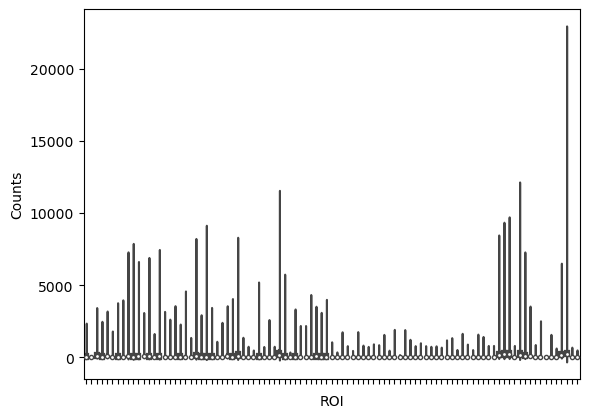

In [7]:
a = seaborn.violinplot(data = spdf, x = "ROI", y = "Counts")


a.set(xticklabels=[]) 


a

The distribution of counts across each ROI. Clearly, the distribution of gene counts vary wildly between each sample. This suggests that data normalization is necessary for proper statistical analysis of the data. 

<AxesSubplot:xlabel='ROI', ylabel='LogSignalToNoise'>

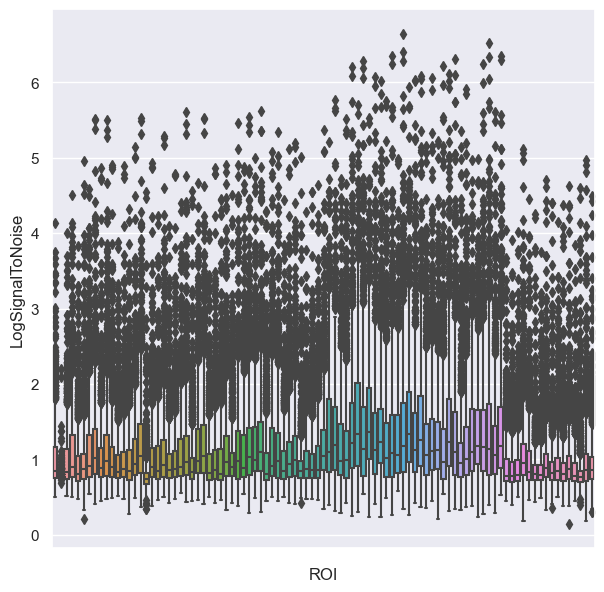

In [9]:
sgn = data.copy()    

targetCountMatrix = qc.SignalToNoise(sgn)        
    
sigNoiseDf = pd.melt(targetCountMatrix, id_vars='TargetName', value_vars=data.keys())

sigNoiseDf = sigNoiseDf.rename(columns = \
                   {"TargetName" : "Gene", "variable": "ROI", "value" : "LogSignalToNoise"})


plt.figure(figsize=(7,7))

seaborn.set(rc={'figure.figsize':(10,10)})
a = seaborn.boxplot(data = sigNoiseDf, x = "ROI", y = "LogSignalToNoise")


a.set(xticklabels=[]) 


a

The plot shows the log signal to noise ratio across all samples. 

# Step 5 - Q3 Normalization and Filtering 

The next steps in the QC is to perform q3 normalization and filter genes. Q3 normalization will also be followed by performing log1p on the data, so that the log expression is the main focus. The filtering will be based on AOI surface area, defined by the SegmentProperties dataset. Filtering will also be performed on the log expression of each sample. If the sample has low expression for a majority of genes, it will be dropped. 



[Text(0.5, 1.0, 'Normalized Counts')]

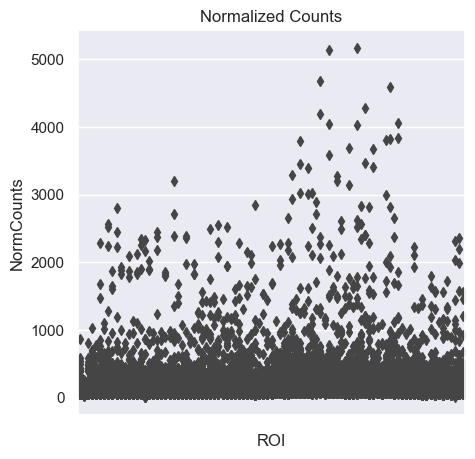

In [11]:

a = qc.q3(data, copy = True)

q3Df = pd.melt(a, id_vars='TargetName', value_vars=a.keys())

q3Df = q3Df.rename(columns = \
                   {"TargetName" : "Gene", "variable": "ROI", "value" : "NormCounts"})

plt.figure(figsize=(5,5))

b = seaborn.boxplot(data = q3Df, x = "ROI", y = "NormCounts")

b.set(xticklabels=[]) 

b.set(title = "Normalized Counts")

The Normalized Counts. Note that, without applying the logarithm, the data is still difficult to interpret. 

/Users/gabrielf/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


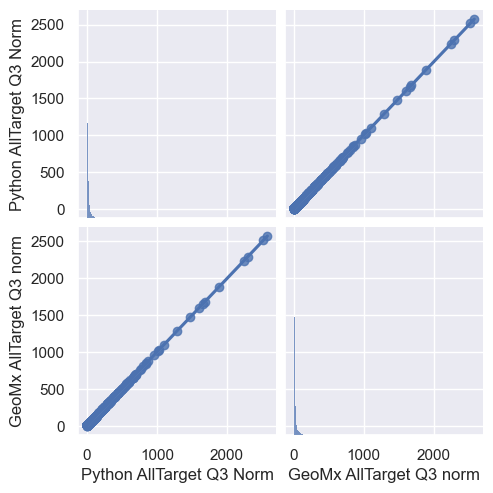

In [12]:

# Validation

# This step is not necessary for the analysis. It shows that the q3 normalization lines up with a validated dataset. 


normalized = pd.read_excel("sunny_q3norm.xlsx", sheet_name = "TargetCountMatrix")

# Create a copy of both test and validation datasets, then drop (most) samples.
# Will then want to melt these into new datasets for use in making scatterplots...

toTest = a.copy()
valSet = normalized.copy()

# Dropping step 


removing = toTest.keys()[10:]

toTest = toTest.drop(removing, axis = 1)
#toTest = toTest.drop("TargetName", axis = 1)

valSet = valSet.drop(removing, axis = 1)
#valSet = valSet.drop("TargetName", axis = 1)


# Melting step

testMelt = pd.melt(toTest, id_vars='TargetName', value_vars=toTest.keys())
testMelt = testMelt.rename(columns = \
                    {"TargetName" : "Gene", "variable": "ROI", "value" : "Python AllTarget Q3 Norm"})


valMelt = pd.melt(valSet, id_vars='TargetName', value_vars=valSet.keys())
valMelt = valMelt.rename(columns = \
                    {"TargetName" : "Gene", "variable": "ROI", "value" : "GeoMx AllTarget Q3 norm"})


testMelt["GeoMx AllTarget Q3 norm"] = valMelt["GeoMx AllTarget Q3 norm"]

testMelt

seaborn.pairplot(testMelt, kind = "reg")


Validation showing that this q3 function works as intended. Such an analysis may not be necessary for the QC process.

<AxesSubplot:ylabel='Count'>

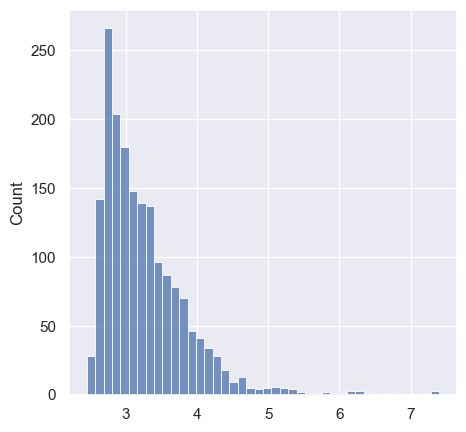

In [13]:
means = []

for i in range(len(a)):
    
    means.append(np.log1p(np.mean(a.iloc[i].values[1:])))
        
means = np.sort(means)



fig = plt.figure(figsize=(5,5))


seaborn.histplot(means)




Performing the logarithm on the mean of the data and displaying it as a histogram. 

# Step 6 - Sanity Check

Perhaps a useful sanity check is to compare expression of key genes in their respective segments. This shows that segmentation is working (or shows which samples have subpar segmentation). Here, the panelDict object is a useful way to define which genes are expected to be found in each segment/sample. In this specific instance, it can be seen that the segmentation of one of the slides appears to be swapped. So this slide may be dropped during downstream analysis.

In [14]:

segment = ['Segment 1', 'Segment 2'] # Ensure that segment contains the name of the segments as it is found in the data

panelDict = {"panck_panel": ['KRT7','KRT5','KRT6','KRT20','KRT8'],\
             "cd45_panel" : ['PTPRC', 'JAK3', 'JAK1']}

# The panelDict keys can be anything, but the values must be names of genes present in the dataset. 


In [16]:
snrDf = qc.SignalToNoise(data, return_log = False) # The non-log signal to noise ratio

In [18]:
newdf = qc.LongPanelData(data, segmentProperties, snrDf, panelDict, segment)

<AxesSubplot:title={'center':'Sample 98016'}, xlabel='Segment', ylabel='SNR'>

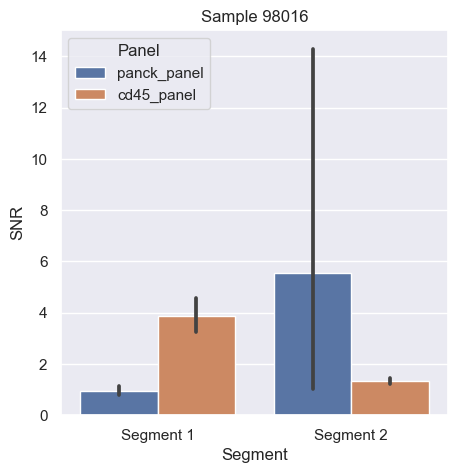

In [19]:

# Parsing the dataframe for a specific sample name. In this instance, the sample name is "98016" but will be different 
# for other datasets 

sampName = "98016" # Change this

bool98 = [sampName in newdf["SampleName"][i] for i in range(len(newdf))]

pewdf = newdf.loc[bool98]

fig = plt.figure(figsize=(5,5))
plt.title("Sample 98016")


seaborn.barplot(data = pewdf, x = "Segment", y = "SNR", hue = "Panel")

This sample appears to have swapped segmentation. According to SegmentProperties, segment 1 is the panCK positive segment, and segment 2 is the immune (cd45) segment. This suggests that there may be incorrect labelling, or that the staining was poor (the latter of which appears to be the case for this specific slide). 

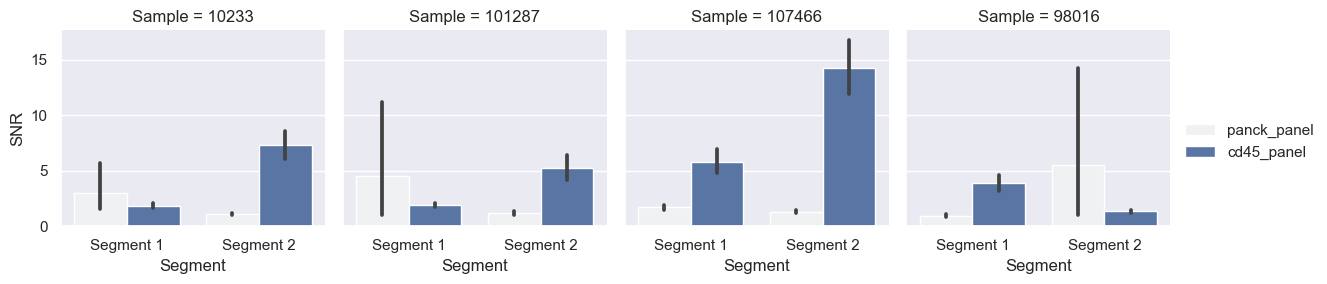

In [20]:

# Use facetgrid to plot the two panels. Clearly, some samples have better signal than others. The "Segment 1" should have high
# panCK and "Segment 2" should have high cd45. This information can be found in the SegmentProperties sheet. 

g = seaborn.FacetGrid(data = newdf, col = "Sample")
g.map_dataframe(seaborn.barplot, data = newdf, x = "Segment", y = "SNR", hue = "Panel")
g.add_legend()

FacetGrid allows all the samples to be shown at once. The segmentation is good for the first two samples, but questionnable for the other two. 

<AxesSubplot:title={'center':'All Samples'}, xlabel='Segment', ylabel='SNR'>

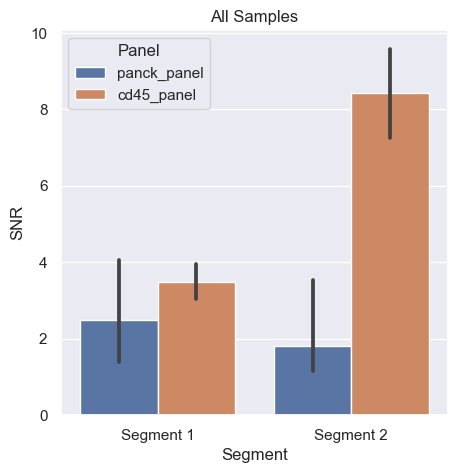

In [22]:

# Next, we will show how one can add extra genes to the panel to see if the results change. Simply define a new panel dict and 
# rerun. Here the genes KRT6 and EPCAM are added to the panCK panel. 

krepDict = {"panck_panel": ['KRT7','KRT5','KRT6','KRT20','KRT8', 'KRT19', 'EPCAM'],
            "cd45_panel" : ['PTPRC', 'JAK3', 'JAK1']}

includeNew = qc.LongPanelData(data, segmentProperties, snrDf, panelDict, segment)

fig = plt.figure(figsize=(5,5))
plt.title("All Samples")


seaborn.barplot(data = includeNew, x = "Segment", y = "SNR", hue = "Panel")

All samples plotted using the two extra genes. A plot such as this shows the overall signal in the data, but does not show which samples may be problematic. Clearly, the data isn't perfect since the panCK segment (segment 1) has low expression of panCK panel genes. 

<AxesSubplot:title={'center':'Sample 107466 with KRT19 and EPCAM'}, xlabel='Segment', ylabel='SNR'>

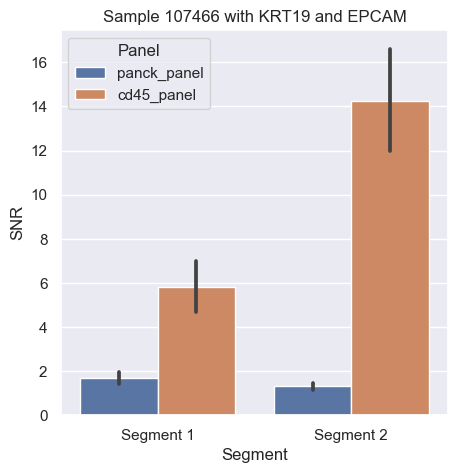

In [23]:

sampName = "107466" # Change this


bool107466 = [sampName in includeNew["SampleName"][i] for i in range(len(includeNew))]
panCKsample107466 = includeNew.loc[bool107466]
fig = plt.figure(figsize=(5,5))
plt.title("Sample 107466 with KRT19 and EPCAM")

seaborn.barplot(data = panCKsample107466, x = "Segment", y = "SNR", hue = "Panel")

How the slide 107466 looks with the two genes added. The SNR does not seem to be greatly affected by the segmentation. That is, segment 1 still has too low SNR for the genes expected from the panCK panel.

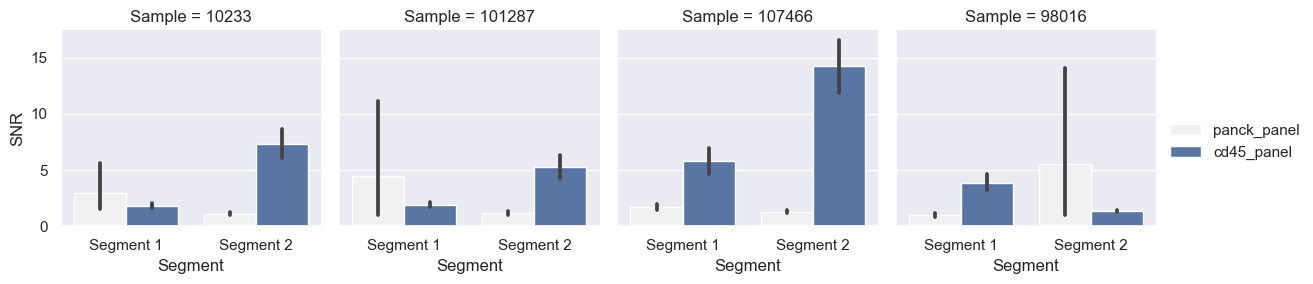

In [24]:

g = seaborn.FacetGrid(data = includeNew, col = "Sample")
g.map_dataframe(seaborn.barplot, data = includeNew, x = "Segment", y = "SNR", hue = "Panel")
g.add_legend()


Next, plotting the panels with the two extra genes provides a similar result. The signal to noise ratio does not appear to follow the segmentation too closely for the 107466 and 98016 samples. 

# Step 7 - Clustering

Clustering may be useful to show the separation in the data. Here, PCA is used to cluster samples and a scatterplot is used to display the results.

In [25]:
pcaDf = qc.PCAData(qc.q3(data, copy = True))

pcaDf["CK+"] = ["1" in pcaDf["Segment"][i] for i in range(len(pcaDf["Segment"]))]

<AxesSubplot:title={'center':'Principal Component Clustering by PCK Marker'}, xlabel='PCA1', ylabel='PCA2'>

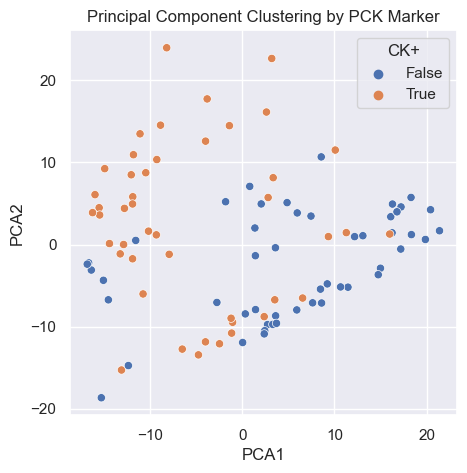

In [26]:
fig = plt.figure(figsize=(5,5))
plt.title("Principal Component Clustering by PCK Marker")

seaborn.scatterplot(data = pcaDf, x = "PCA1", y = "PCA2", hue = "CK+")

<AxesSubplot:title={'center':'Principal Component Clustering by Slide'}, xlabel='PCA1', ylabel='PCA2'>

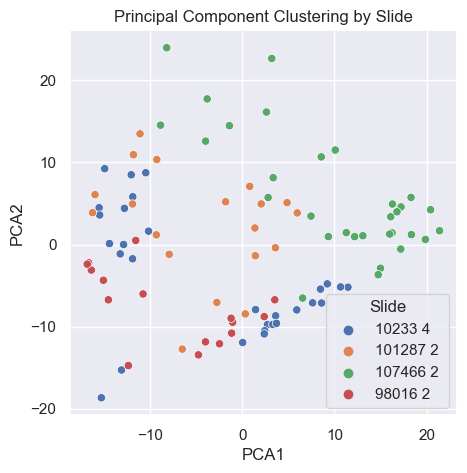

In [27]:
fig = plt.figure(figsize=(5,5))
plt.title("Principal Component Clustering by Slide")

seaborn.scatterplot(data = pcaDf, x = "PCA1", y = "PCA2", hue = "Slide")

In [29]:
sampleLabels = {"Progressor":["101287", "10233"], "Non-progressor":["98016", "107466"]}

qc.PCALabelSamples(pcaDf, sampleLabels)

,PCA1,PCA2,Slide,ROI,Segment,CK+,Progressor
0,-15.506044,4.478620,10233 4,001,Segment 1,True,Progressor
1,-15.270314,-18.650934,10233 4,001,Segment 2,False,Progressor
2,-15.450845,3.594936,10233 4,002,Segment 1,True,Progressor
3,-14.902680,9.235204,10233 4,003,Segment 1,True,Progressor
4,-14.388024,0.117755,10233 4,004,Segment 1,True,Progressor
...,...,...,...,...,...,...,...
90,-1.200104,-8.974196,98016 2,016,Segment 1,True,Non-progressor
91,-15.044428,-4.354446,98016 2,016,Segment 2,False,Non-progressor
92,-12.337705,-14.733886,98016 2,017,Segment 2,False,Non-progressor
93,2.391060,-8.777339,98016 2,018,Segment 1,True,Non-progressor


<AxesSubplot:title={'center':'Principal Component Clustering by Progressor Status'}, xlabel='PCA1', ylabel='PCA2'>

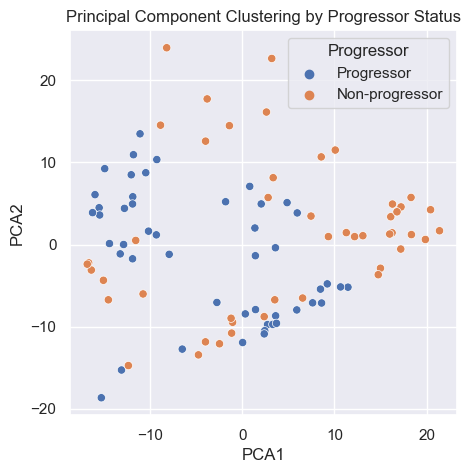

In [30]:
fig = plt.figure(figsize=(5,5))
plt.title("Principal Component Clustering by Progressor Status")

seaborn.scatterplot(data = pcaDf, x = "PCA1", y = "PCA2", hue = "Progressor")

In [31]:
# Rename the CK+ column into PCK and CD45 instead of true and false. 

cd45ORpck = []

for i in pcaDf["CK+"]:
    if i:
        cd45ORpck.append("PCK")
    else:
        cd45ORpck.append("CD45")
        
pcaDf["Marker Type"] = cd45ORpck

<AxesSubplot:title={'center':'Principal Component Clustering by Marker'}, xlabel='PCA1', ylabel='PCA2'>

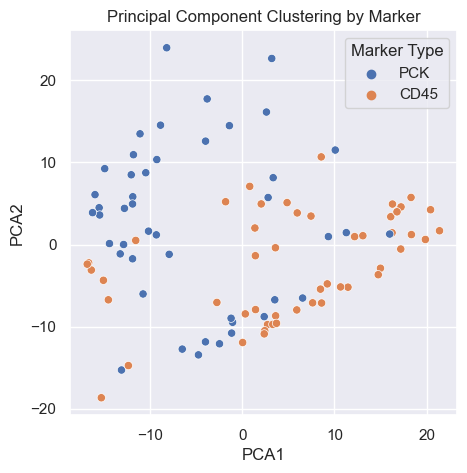

In [32]:
fig = plt.figure(figsize=(5,5))
plt.title("Principal Component Clustering by Marker")

seaborn.scatterplot(data = pcaDf, x = "PCA1", y = "PCA2", hue = "Marker Type")

# Step 8 - Writing to CSV

Since all QC steps have been completed, it is now necessary to write the data to csv. The order of processing data is log transform -> filtering -> q3 normalization. 

In [21]:
logNormData.to_csv(path_or_buf='logNormData')


In [19]:
highExpressionData = qc.FilterLogExpression(logNormData)
highExpressionData.to_csv(path_or_buf='highExpressionData')